In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from Lineaire.Linear import *
from Loss.BCELoss import BCELoss
from Activation.Tanh import Tanh
from Activation.Sigmoide import Sigmoide
from Encapsulation.AutoEncodeur import AutoEncodeur
from Encapsulation.Sequentiel import Sequentiel
from Encapsulation.Optim import SGD
from Activation.SoftMax import  SoftMax
from Loss.CELogSoftMax import CELogSoftMax

from utils import tools

from icecream import ic


In [1]:
def predict(i, X, Y):
    dim = int(np.sqrt(X.shape[1]))
    
    plt.figure(figsize=(5, 2))  # Ajustez la taille de la figure selon vos besoins
    #plt.title(f'classe = {Y[i]}')
    
    plt.subplot(1, 2, 1)  # Première cellule de la grille
    plt.imshow(X[i].reshape((dim,dim)), cmap='grey')
    plt.title(f'Image originale ({Y[i]})')
    pred = opt._net.forward(X[i].reshape((1,dim**2)))
    plt.subplot(1, 2, 2)  # Deuxième cellule de la grille
    plt.imshow(pred.reshape((dim,dim)), cmap='grey')
    plt.title('Image reconstruite')
    plt.show()
    #print('classe = ', y_train[i])
    
def afficher_images_cluster_rep(groupe_df_cluster):
    plt.figure(figsize=(10, 4))

    for i, image in enumerate(groupe_df_cluster.RepresentationLatente.head(10)):
        
        plt.subplot(2, 5, i+1)
        
        
        plt.imshow(trainx[image].reshape(16, 16), cmap='gray')
        plt.title(train_y[image])
        plt.axis('off')
        
    # Ajuster les marges
    plt.tight_layout()
    plt.show()
    
def afficher_images_cluster(groupe_df_cluster):
    plt.figure(figsize=(10, 4))

    for i, image in enumerate(groupe_df_cluster.Image.head(10)):
        
        plt.subplot(2, 5, i+1)
        
        
        plt.imshow(trainx[image].reshape(16, 16), cmap='gray')
        plt.title(train_y[image])
        plt.axis('off')
        
    # Ajuster les marges
    plt.tight_layout()
    plt.show()

def pred_classes(y_hat):
    classes_predites = np.argmax(y_hat, axis=1)
    predictions = []
    for y in classes_predites:
        predictions.append(transform_one_hot(y))
    
    predictions= np.array(predictions)
    return predictions

def score(y, yhat):
    predictions = pred_classes(yhat)
    comparaison = (predictions == 1) * (y == 1)
    s = np.sum(comparaison)
    return s, s/len(yhat)

def transform_one_hot_vector(classe):
    a =  np.zeros(10)
    a[classe] = 1
    return a

def transform_one_hot(y):
    one_hot_vectors = []
    for yi in y:
        one_hot_vectors.append(transform_one_hot_vector(yi))
    return np.array(one_hot_vectors)

In [ ]:
np.random.seed(5)

# Dataset: SKLearn Digits

## Chargement et standardisation des données

In [2]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Avec minmax scaler ca marche pas, toujours la meme image reconstruite

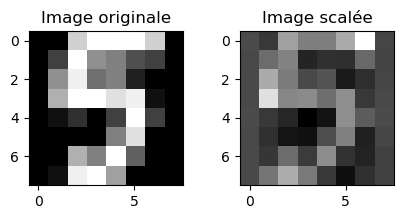

In [6]:
plt.figure(figsize=(5,2))
plt.subplot(1,2,1)
plt.title("Image originale")
plt.imshow(X_train[5].reshape((8,8)), cmap='grey')
plt.subplot(1,2,2)
plt.imshow(X_train_scaled[5].reshape((8,8)), cmap='grey')
plt.title("Image scalée")
plt.show()

## Expérimentations

In [7]:
loss_bce = BCELoss()
lineaire1 = Linear(X_train.shape[1], 32, init_type=1)
lineaire2 = Linear(32, 8, init_type=1)
lineaire3 = Linear(8, 32, init_type=1)
lineaire4 = Linear(32, 64, init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)

net, couts, opt = SGD(net, X_train_scaled, X_train_scaled,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-1, shuffle=True)


ic| X.shape: (1437, 64), Y.shape: (1437, 64)


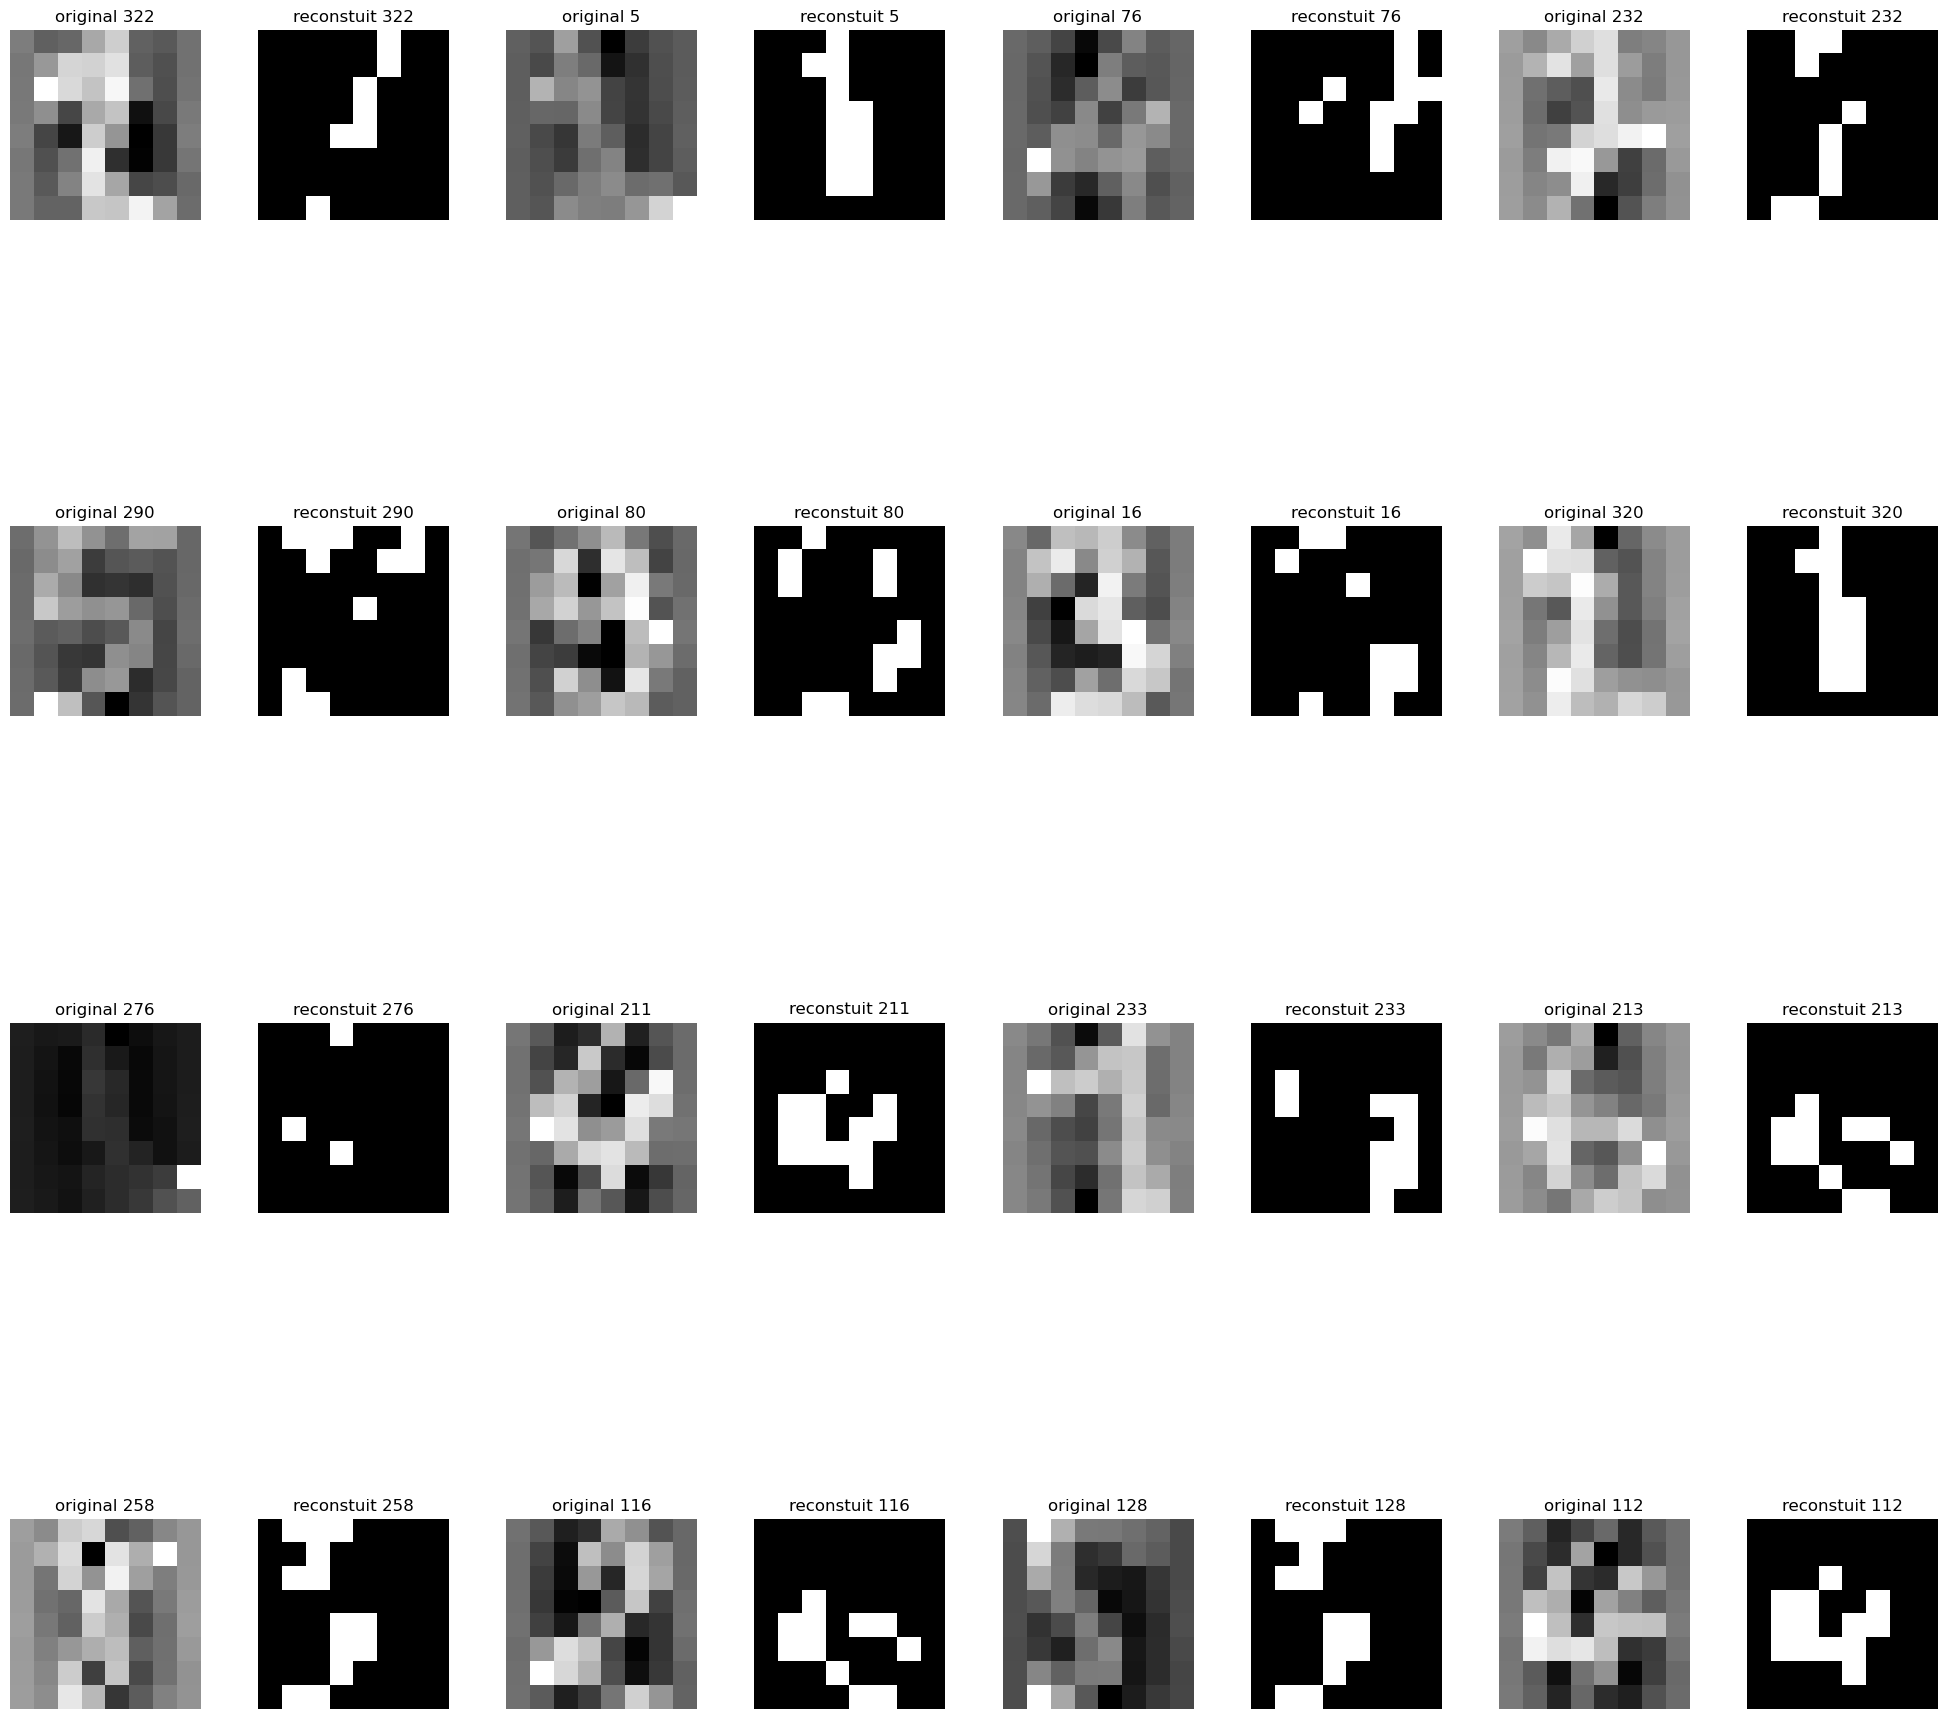

In [10]:
tools.print_auto_encoder(X_test_scaled, net, 16, 8)

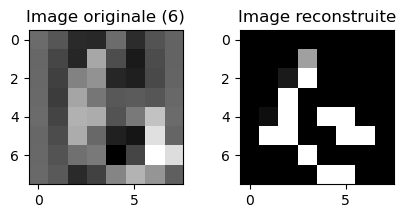

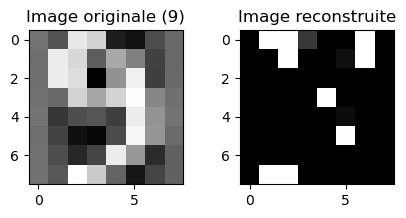

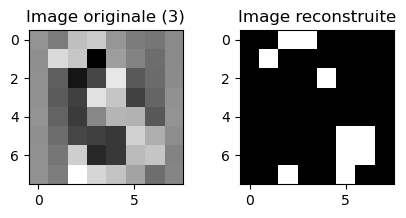

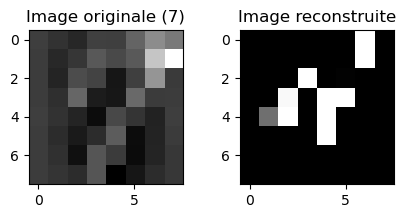

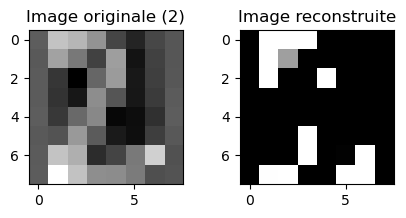

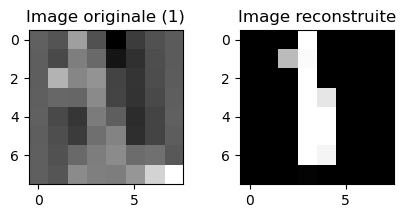

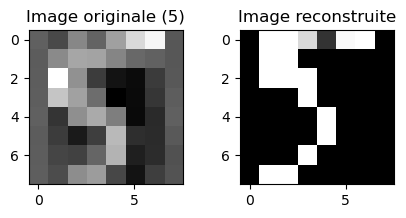

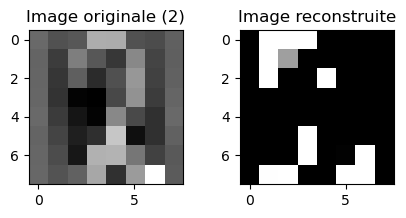

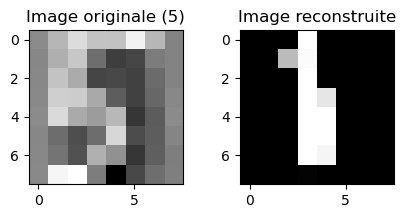

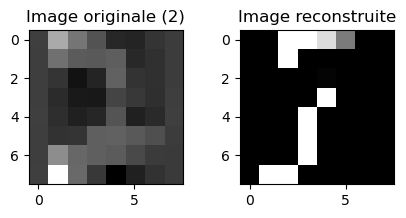

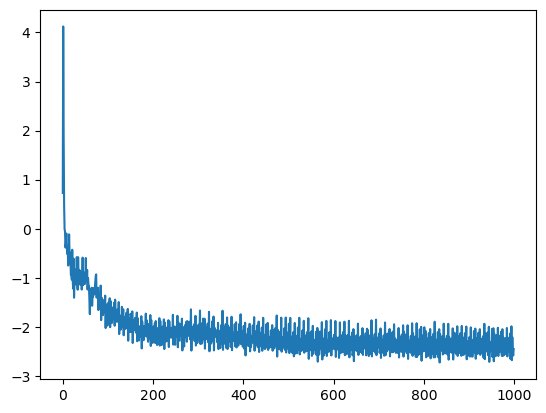

In [41]:
n=10
predict(n, X_test_scaled, y_test)

plt.plot(range(len(couts)), couts)
plt.show()

# Dataset: USPS

In [10]:
path_train = "dataset/USPS_train.txt"
path_test = "dataset/USPS_test.txt"

trainx, train_y = tools.load_usps(path_train)
testx, test_y = tools.load_usps(path_test)

scaler = StandardScaler()
scaler.fit(trainx)
trainx = scaler.transform(trainx)
testx = scaler.transform(testx)
del scaler

ic(trainx.shape)

ic| trainx.shape: (7291, 256)


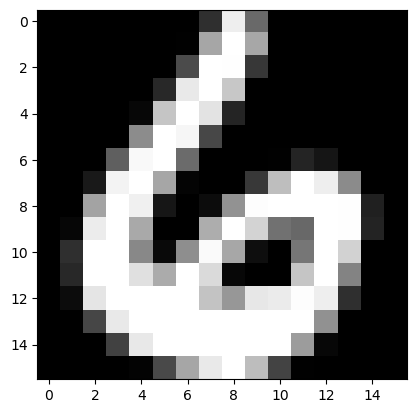

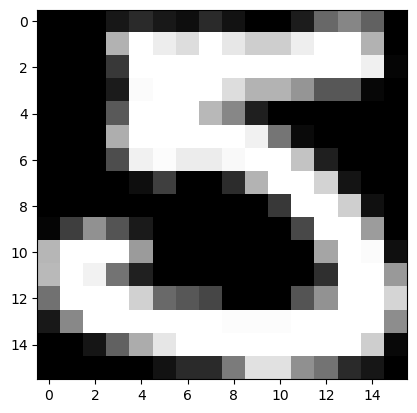

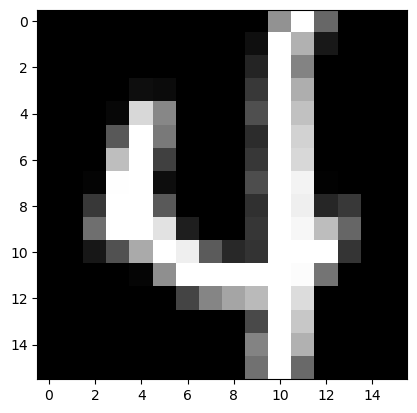

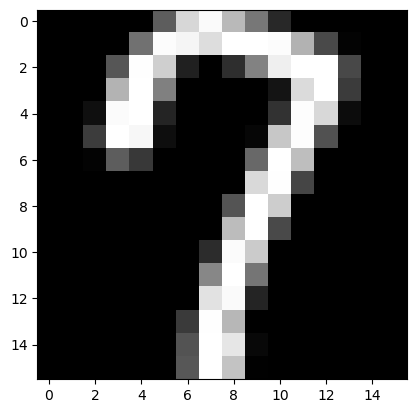

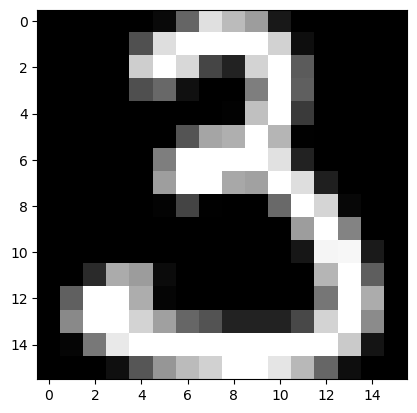

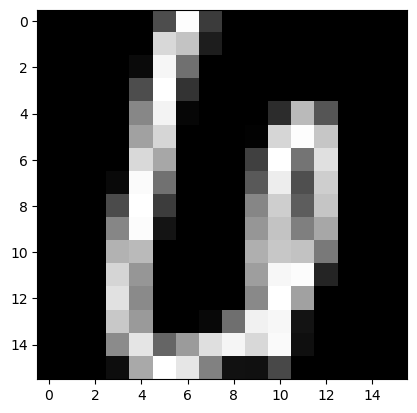

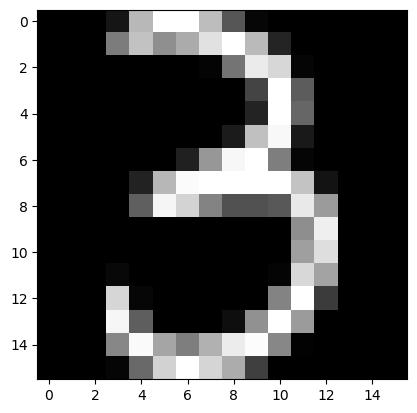

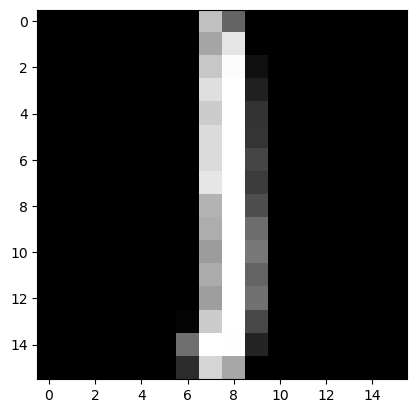

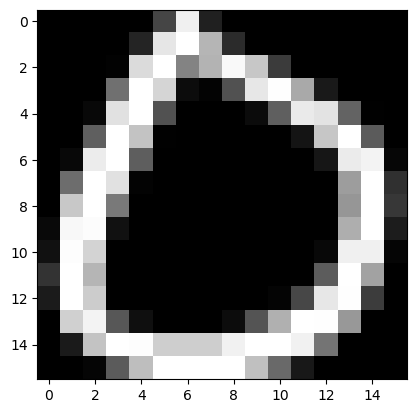

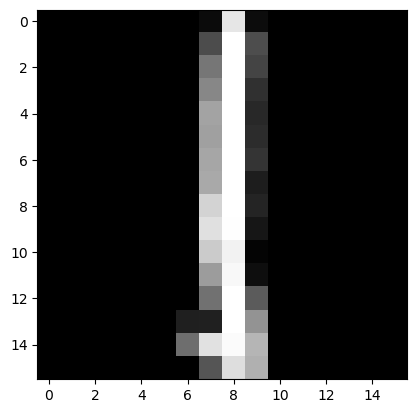

In [44]:
for i in range(10):
    plt.imshow(trainx[i].reshape((16,16)), cmap='grey')
    plt.show()

## Sabrina

In [7]:
out1=64
out2=10

BCE_loss = BCELoss()
modul_lin1 = Linear( trainx.shape[1], out1)
modul_lin2 = Linear(out1, out2)
modul_lin3 = Linear( out2, out1)
modul_lin4 = Linear(out1, trainx.shape[1])

modul_lin3._parameters = modul_lin2._parameters.T
modul_lin4._parameters = modul_lin1._parameters.T

encoder=[modul_lin1,Tanh(),modul_lin2,Tanh()]
decoder=[modul_lin3,Tanh(),modul_lin4,Sigmoide()]

encoder_100_10 = Sequentiel(*(encoder+decoder))

#opt = Optim(encoder_100_10,BCE_loss,1e-4)
nb_iter = 100
#l_loss = SGD(trainx,trainx,100,epochs=1000,shuffle=True)
net, couts, opt = SGD(encoder_100_10, trainx, trainx, nb_batch=10, loss=BCE_loss, nb_epochs=nb_iter, eps=1e-3, shuffle=False)


ic| X.shape: (7291, 256), Y.shape: (7291, 256)


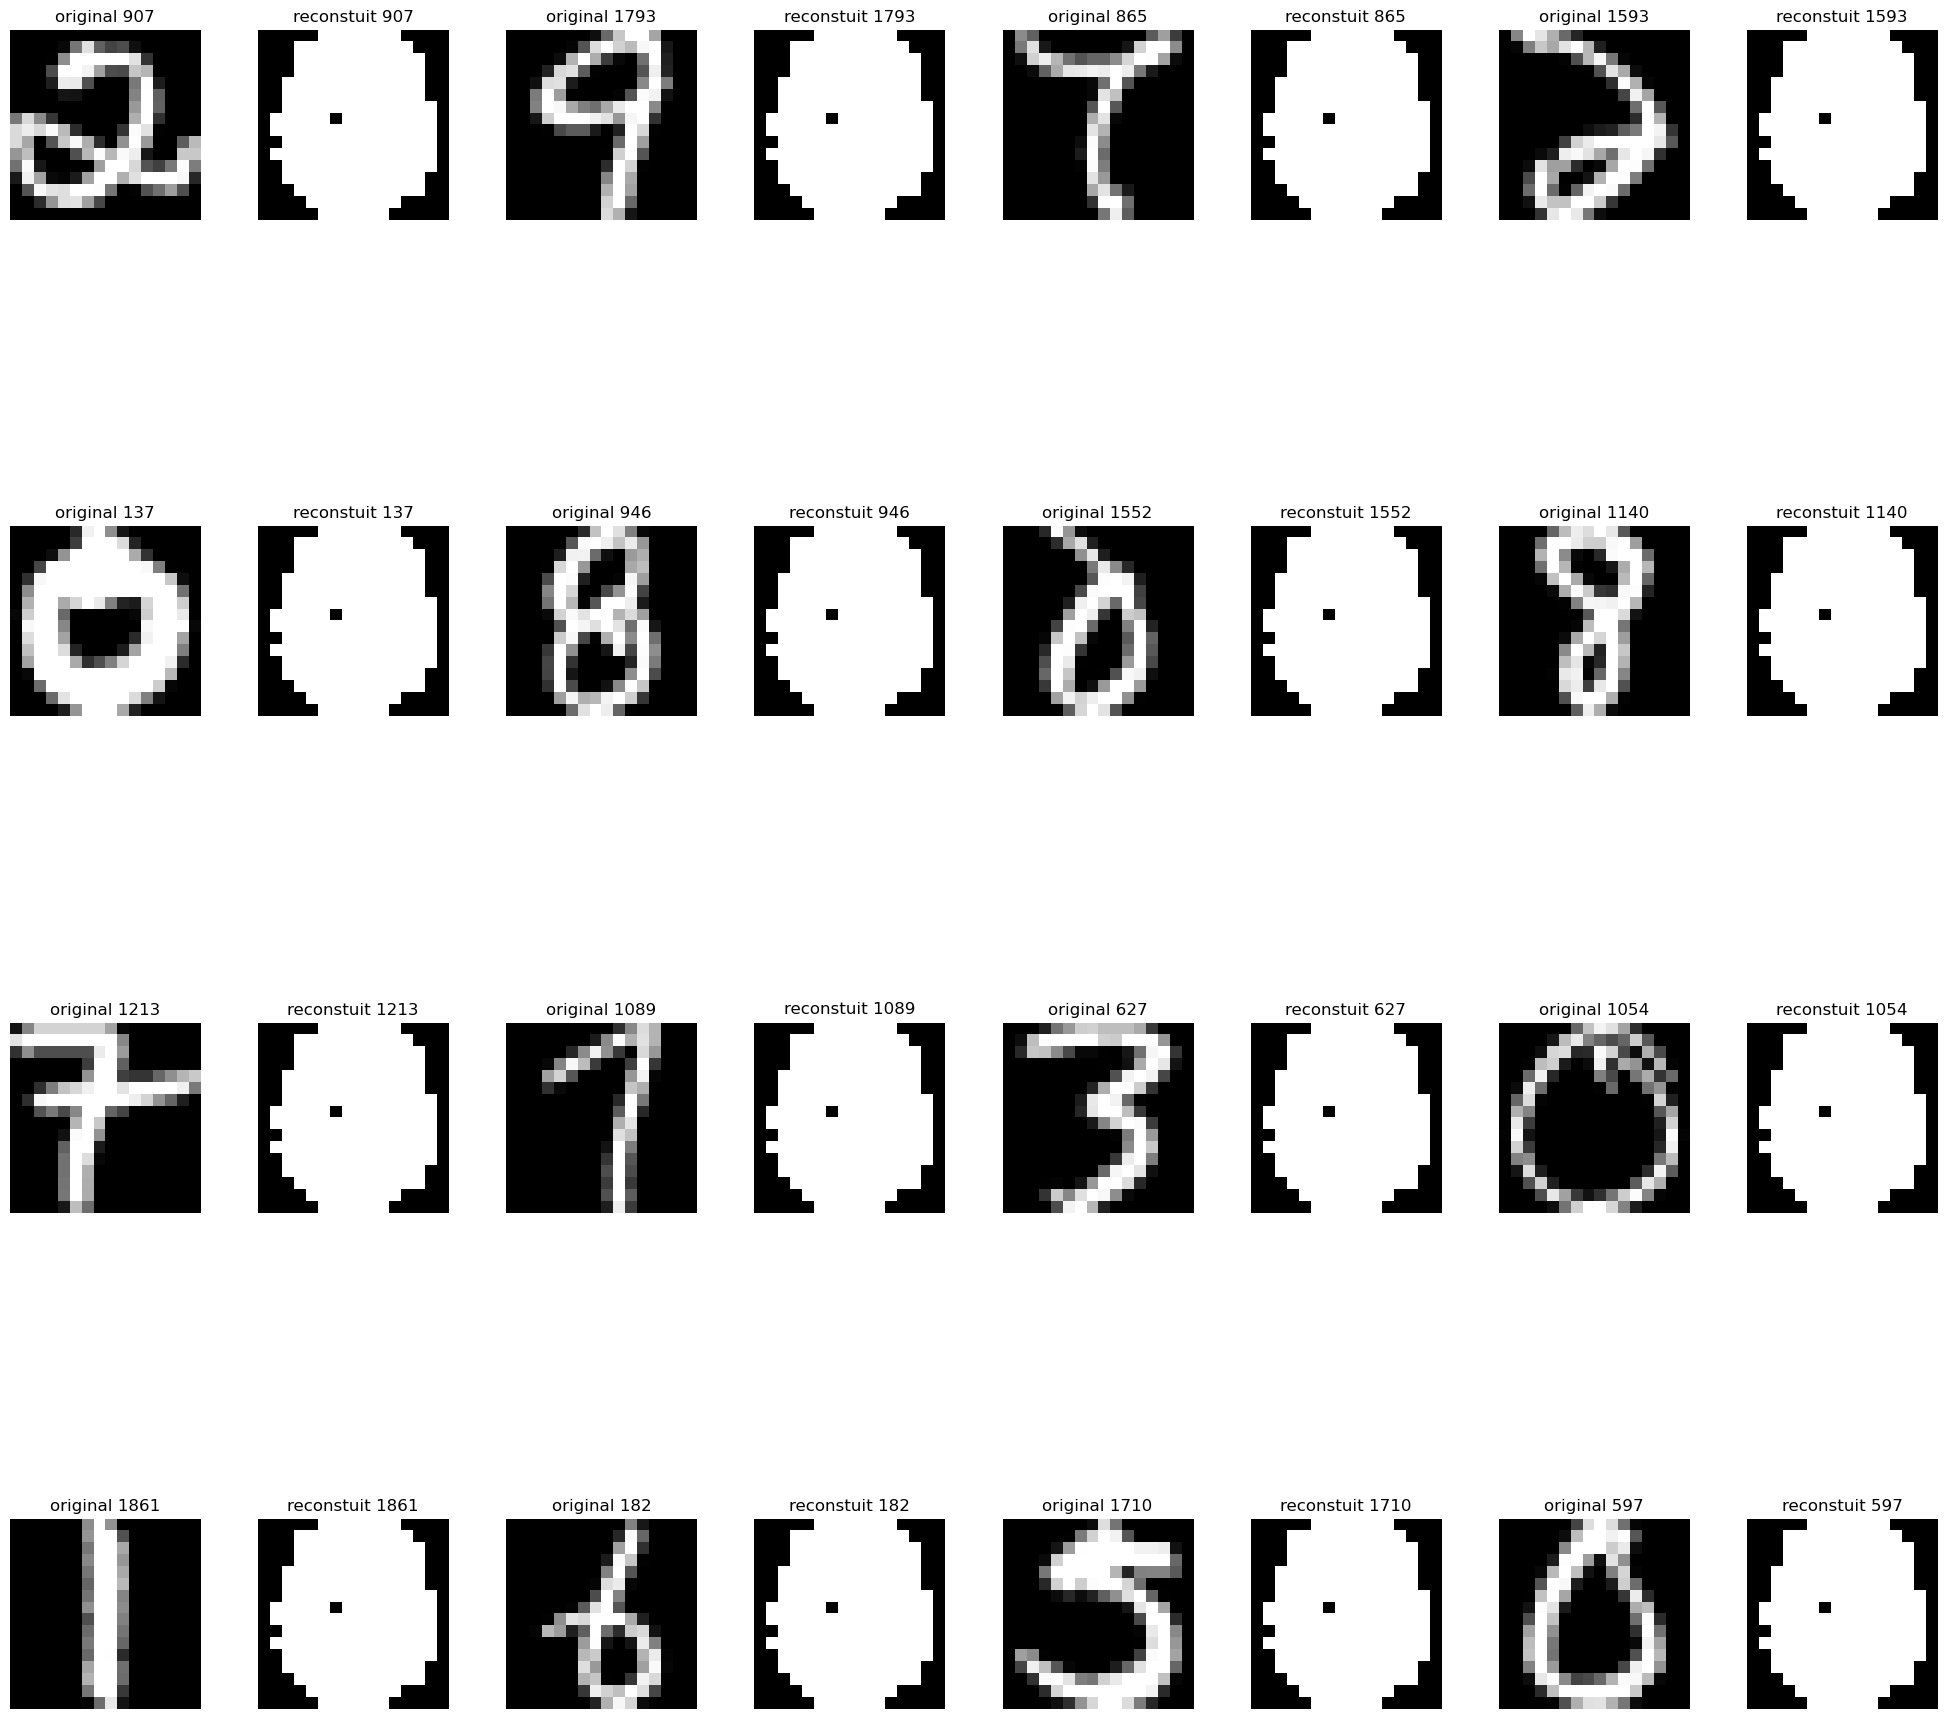

In [8]:
tools.print_auto_encoder(testx,encoder_100_10,16,16)

## Nous

### Config 1

In [5]:
loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 64, init_type=1)
lineaire2 = Linear(64, 10, init_type=1)
lineaire3 = Linear(10, 64, init_type=1)
lineaire4 = Linear(64, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
#net = Sequentiel(lineaire1, tanh, lineaire4, sig)
#opt = Optim(net, loss_mse)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


ic| X.shape: (7291, 256), Y.shape: (7291,

 256)


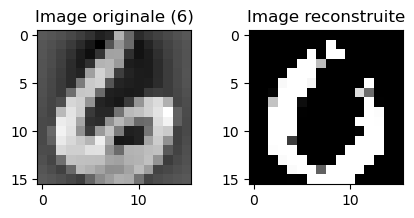

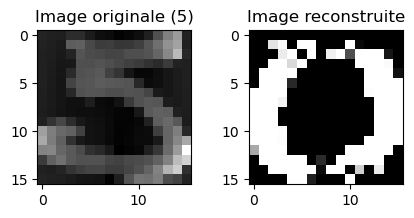

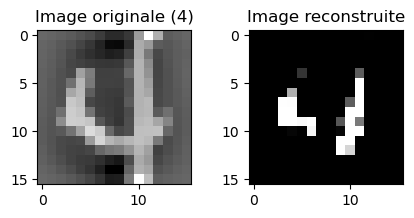

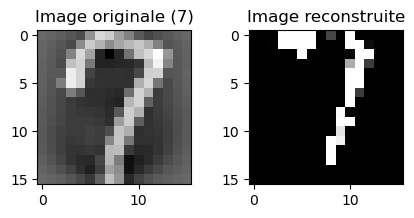

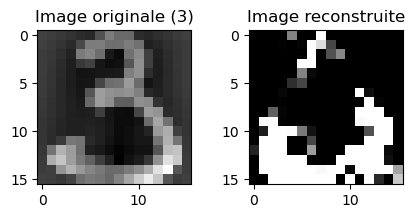

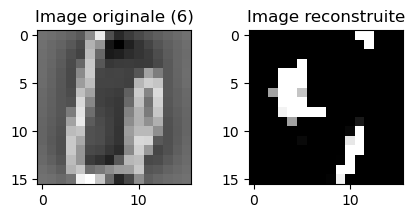

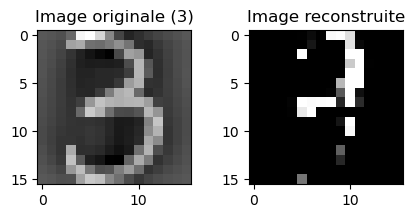

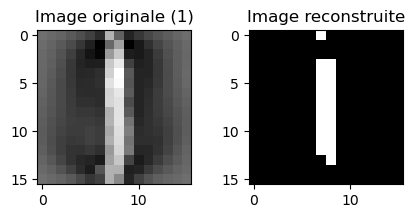

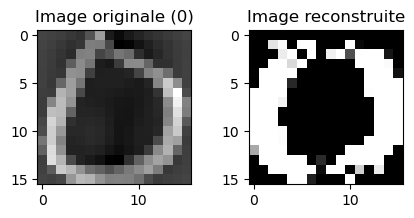

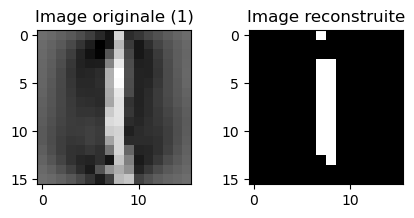

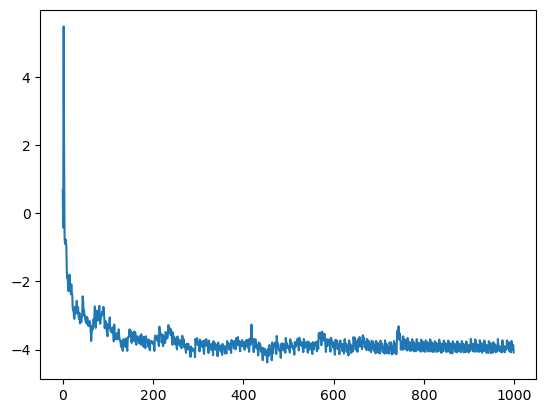

In [6]:
for i in range(10):
    predict(i, trainx, train_y)

plt.plot(range(len(couts)), couts)
plt.show()



### Config 2

In [13]:
loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 128, init_type=1)
lineaire2 = Linear(128, 8, init_type=1)
lineaire3 = Linear(8, 128, init_type=1)
lineaire4 = Linear(128, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
#net = Sequentiel(lineaire1, tanh, lineaire4, sig)
#opt = Optim(net, loss_mse)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


ic| X.shape: (1000, 256), Y.shape: (1000, 256)

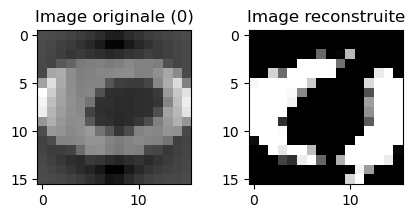

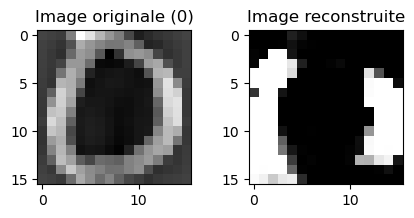

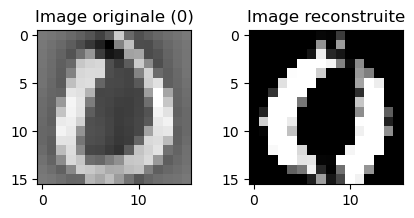

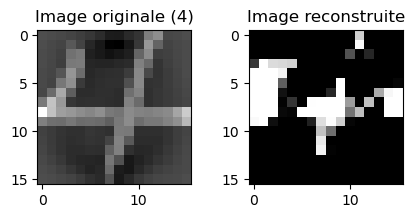

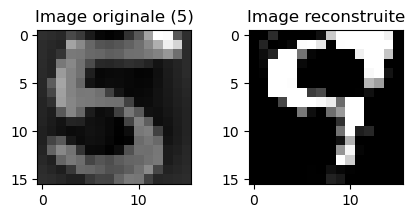

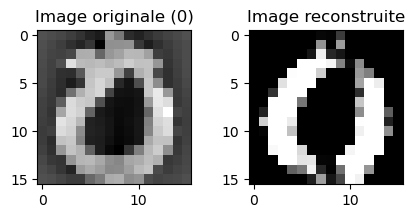

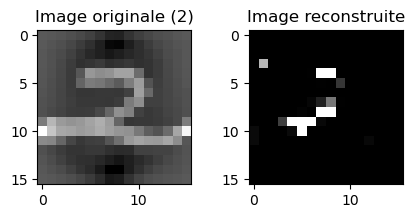

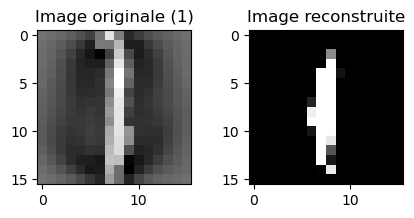

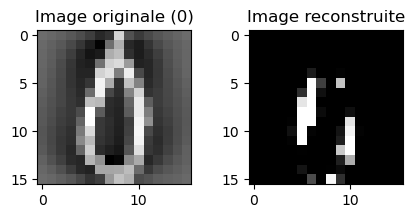

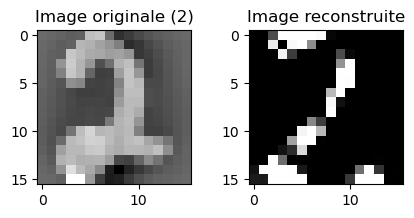

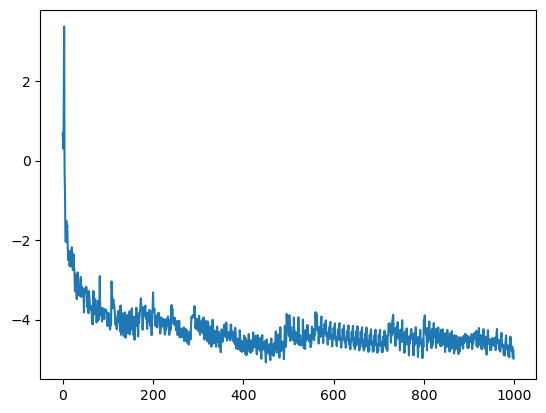

In [16]:
for i in range(10):
    predict(i, trainx, train_y)

plt.plot(range(len(couts)), couts)
plt.show()



### Config 3

In [18]:
trainx = trainx[:3000, :]

scaler = StandardScaler()
trainx = scaler.fit_transform(trainx)

loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 64, init_type=1)
lineaire2 = Linear(64, 2, init_type=1)
lineaire3 = Linear(2, 64, init_type=1)
lineaire4 = Linear(64, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
#net = Sequentiel(lineaire1, tanh, lineaire4, sig)
#opt = Optim(net, loss_mse)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


ic| X.shape: (3000, 256), Y.shape: (3000, 256)


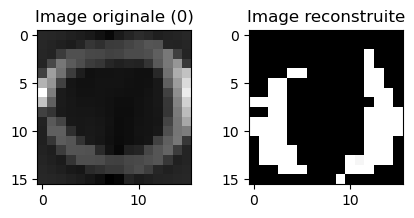

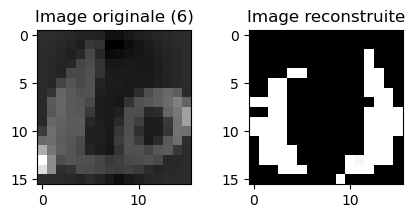

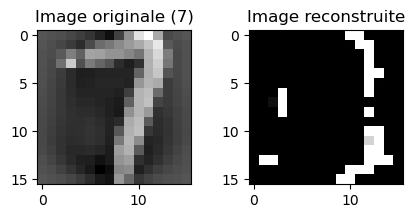

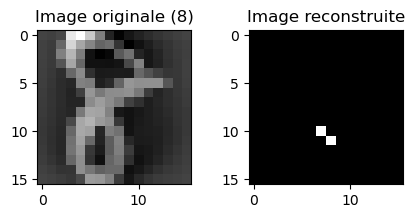

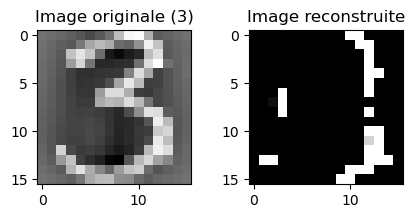

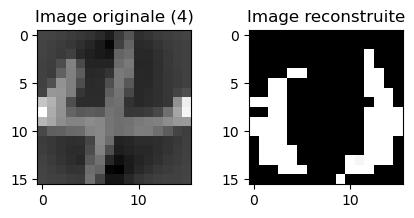

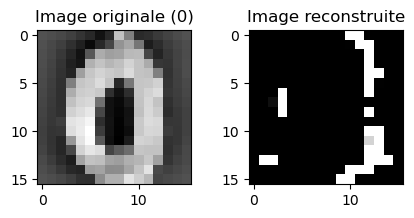

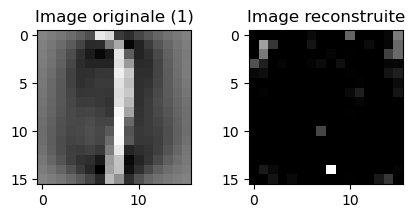

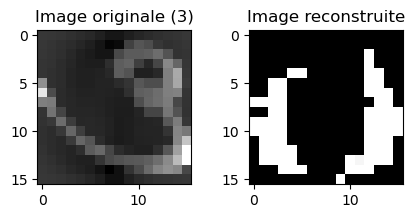

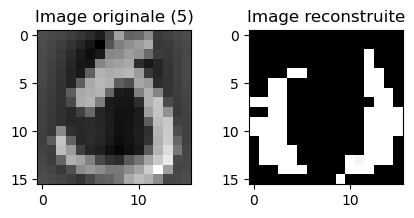

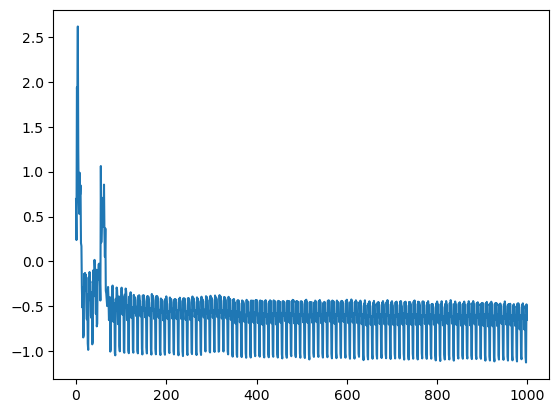

In [19]:
nb_tests = 10
indices = [np.random.randint(0, len(trainx)) for _ in range(nb_tests)]

for i in indices:
    predict(i, trainx, train_y)

plt.plot(range(len(couts)), couts)
plt.show()



### Config 4

In [15]:
loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 100, init_type=1)
lineaire2 = Linear(100, 10, init_type=1)
lineaire3 = Linear(10, 100, init_type=1)
lineaire4 = Linear(100, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
#net = Sequentiel(lineaire1, tanh, lineaire4, sig)
#opt = Optim(net, loss_mse)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


ic| X.shape: (7291, 256), Y.shape: (7291, 256)


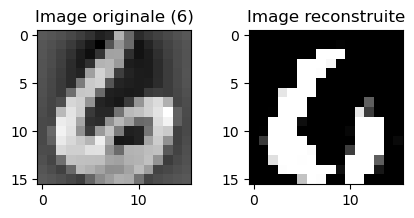

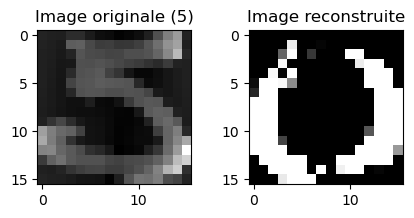

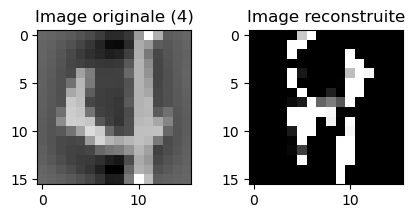

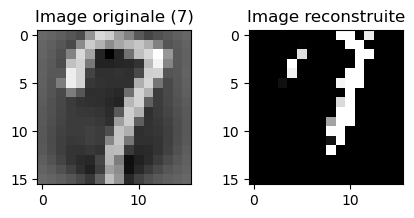

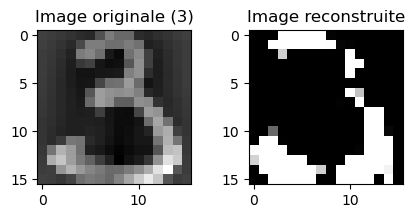

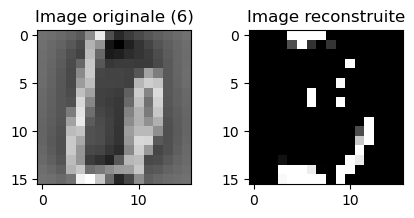

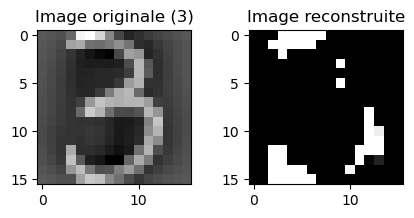

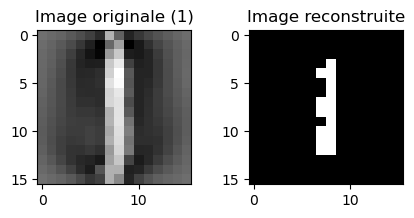

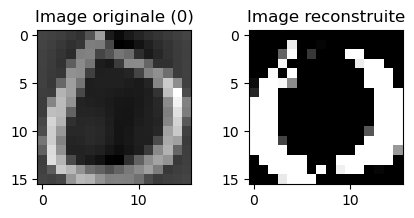

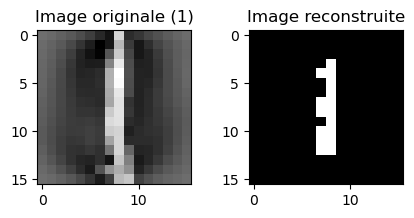

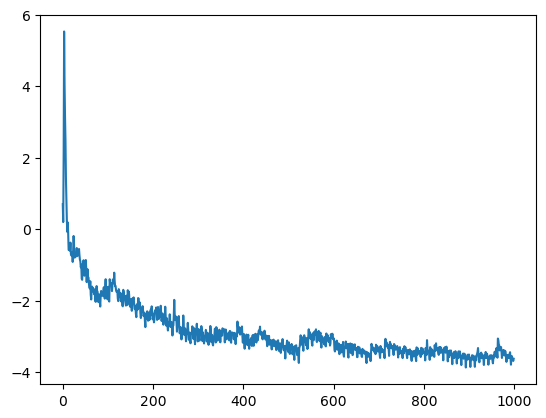

In [16]:
for i in range(10):
    predict(i, trainx, train_y)

plt.plot(range(len(couts)), couts)
plt.show()

In [18]:
loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 100, init_type=1)
lineaire2 = Linear(100, 10, init_type=1)
lineaire3 = Linear(10, 100, init_type=1)
lineaire4 = Linear(100, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
#net = Sequentiel(lineaire1, tanh, lineaire4, sig)
#opt = Optim(net, loss_mse)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


ic| X.shape: (7291, 256), Y.shape: (7291, 256)


MemoryError: Unable to allocate 1.42 MiB for an array with shape (729, 256) and data type float64

# Clustering

## Images originales

In [4]:
trainx = trainx[:1000,:]
train_y = train_y[:1000,:]

loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 64, init_type=1)
lineaire2 = Linear(64, 10, init_type=1)
lineaire3 = Linear(10, 64, init_type=1)
lineaire4 = Linear(64, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
#net = Sequentiel(lineaire1, tanh, lineaire4, sig)
#opt = Optim(net, loss_mse)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


ic| X.shape: (1000, 256), Y.shape: (1000, 256)


In [21]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(trainx)
# Pour obtenir les étiquettes de cluster pour chaque image
labels = kmeans.predict(trainx)
image_cluster = []
# Afficher les étiquettes de cluster pour chaque image
for i in range(len(labels)):
    print("L'image", i, "appartient au cluster", labels[i])
    image_cluster.append((i,labels[i]))


L'image 0 appartient au cluster 0
L'image 1 appartient au cluster 4
L'image 2 appartient au cluster 1
L'image 3 appartient au cluster 1
L'image 4 appartient au cluster 7
L'image 5 appartient au cluster 0
L'image 6 appartient au cluster 7
L'image 7 appartient au cluster 2
L'image 8 appartient au cluster 3
L'image 9 appartient au cluster 2
L'image 10 appartient au cluster 5
L'image 11 appartient au cluster 0
L'image 12 appartient au cluster 2
L'image 13 appartient au cluster 2
L'image 14 appartient au cluster 1
L'image 15 appartient au cluster 1
L'image 16 appartient au cluster 1
L'image 17 appartient au cluster 5
L'image 18 appartient au cluster 3
L'image 19 appartient au cluster 2
L'image 20 appartient au cluster 2
L'image 21 appartient au cluster 1
L'image 22 appartient au cluster 5
L'image 23 appartient au cluster 1
L'image 24 appartient au cluster 7
L'image 25 appartient au cluster 1
L'image 26 appartient au cluster 7
L'image 27 appartient au cluster 1
L'image 28 appartient au clust

In [25]:
df = pd.DataFrame(image_cluster, columns=['Image', 'Cluster'])
df

,Image,Cluster
0,0,0
1,1,4
2,2,1
3,3,1
4,4,7
...,...,...
995,995,1
996,996,1
997,997,1
998,998,0


In [39]:
groupes = df.groupby('Cluster')
groupes_df = []
# Parcourir chaque groupe
for cluster, groupe_df in groupes:
    print("Cluster", cluster)
    print(groupe_df)
    groupes_df.append(groupe_df)
    print("\n")

Cluster 0
     Image  Cluster
0        0        0
5        5        0
11      11        0
31      31        0
39      39        0
..     ...      ...
987    987        0
992    992        0
993    993        0
994    994        0
998    998        0

[123 rows x 2 columns]


Cluster 1
     Image  Cluster
2        2        1
3        3        1
14      14        1
15      15        1
16      16        1
..     ...      ...
980    980        1
990    990        1
995    995        1
996    996        1
997    997        1

[210 rows x 2 columns]


Cluster 2
     Image  Cluster
7        7        2
9        9        2
12      12        2
13      13        2
19      19        2
..     ...      ...
954    954        2
959    959        2
968    968        2
974    974        2
988    988        2

[141 rows x 2 columns]


Cluster 3
     Image  Cluster
8        8        3
18      18        3
68      68        3
91      91        3
101    101        3
..     ...      ...
916    916        3
92

cluster 0


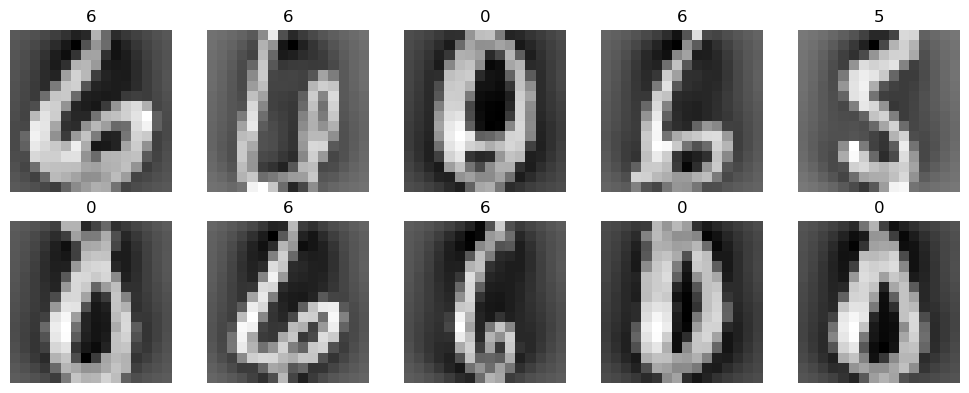

cluster 1


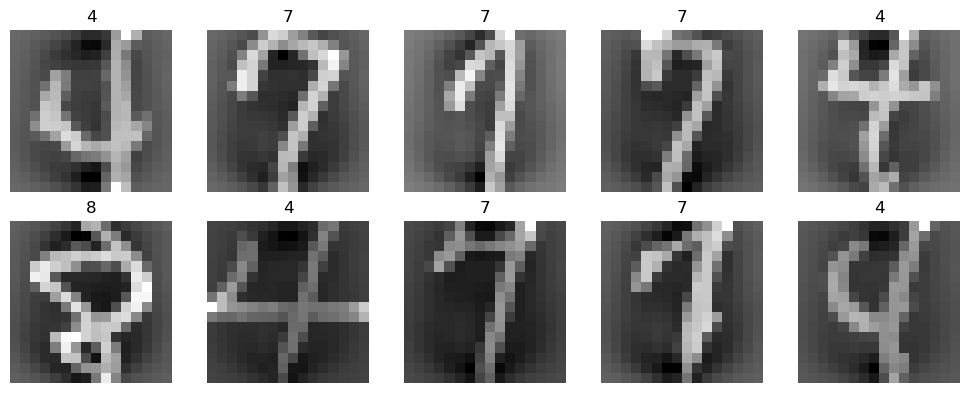

cluster 2


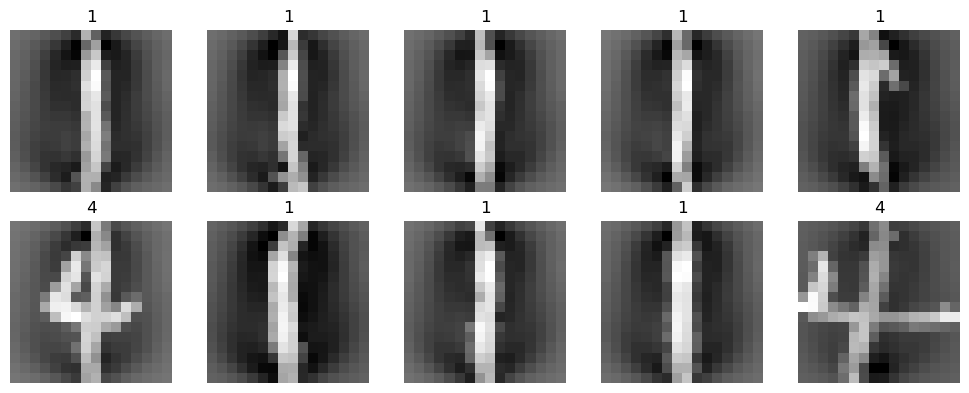

cluster 3


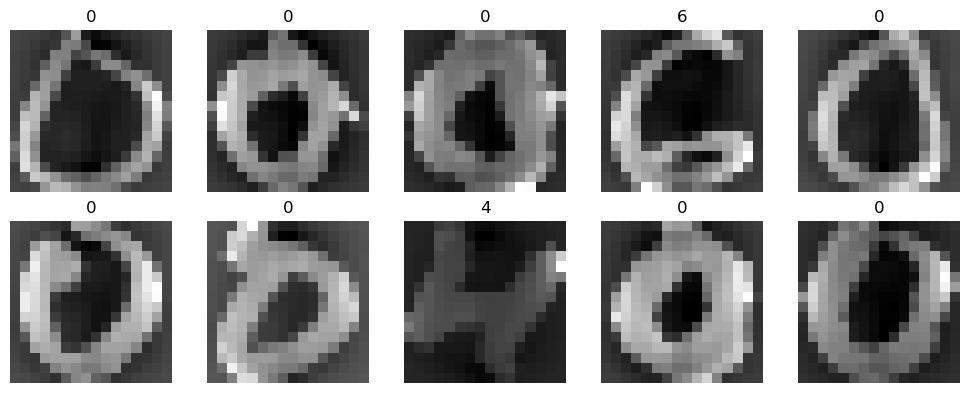

cluster 4


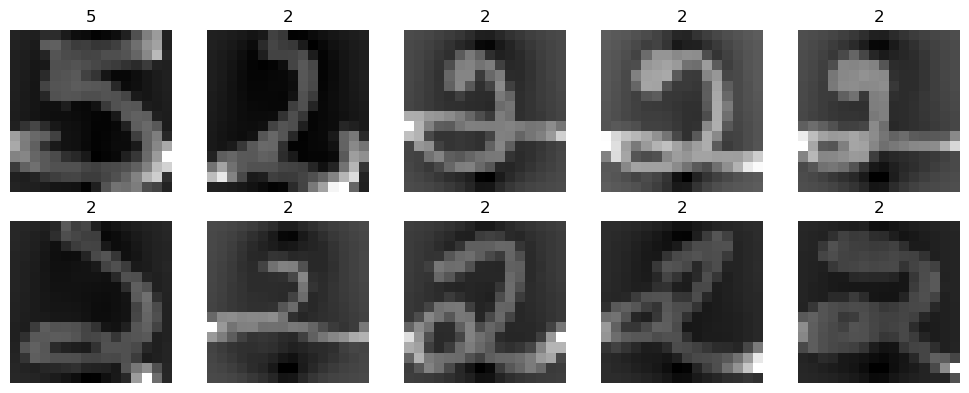

cluster 5


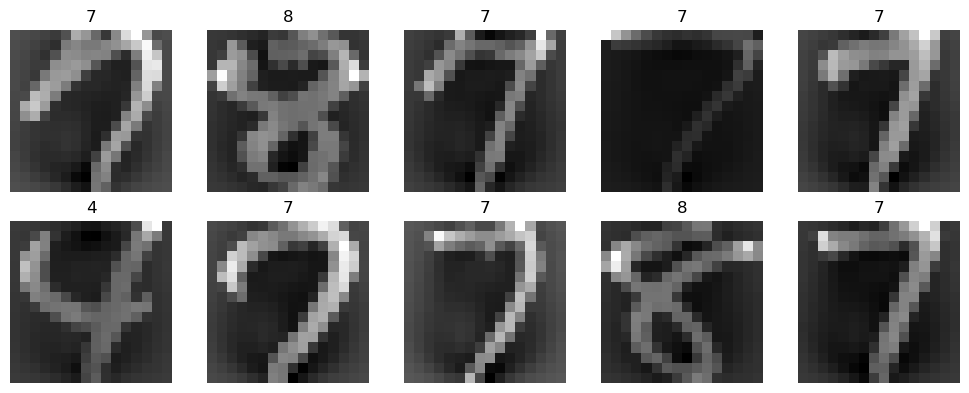

cluster 6


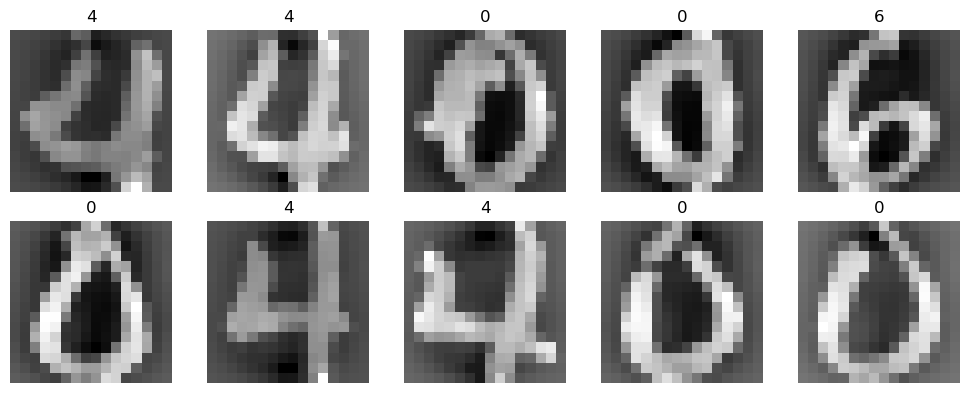

cluster 7


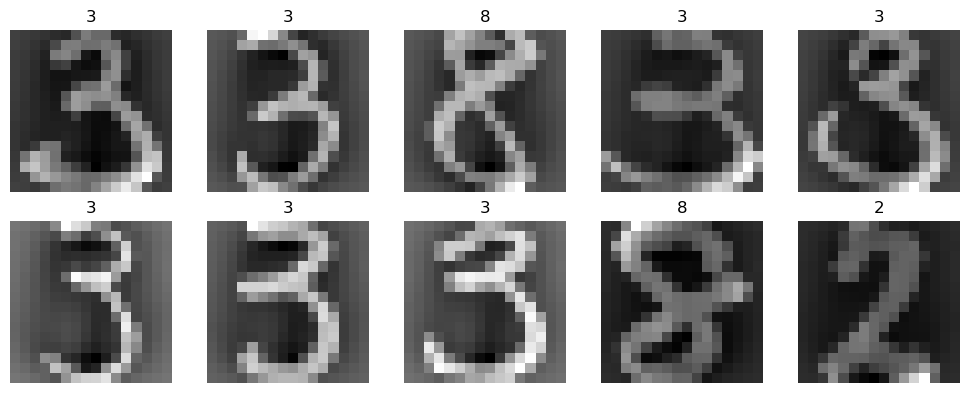

cluster 8


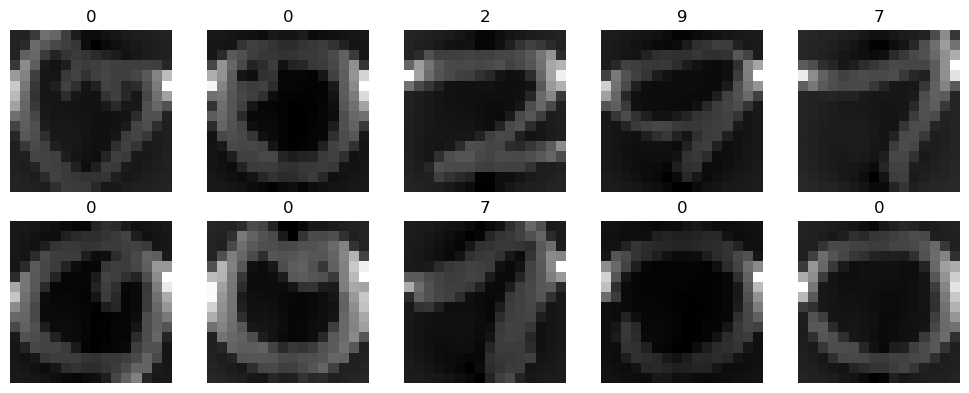

cluster 9


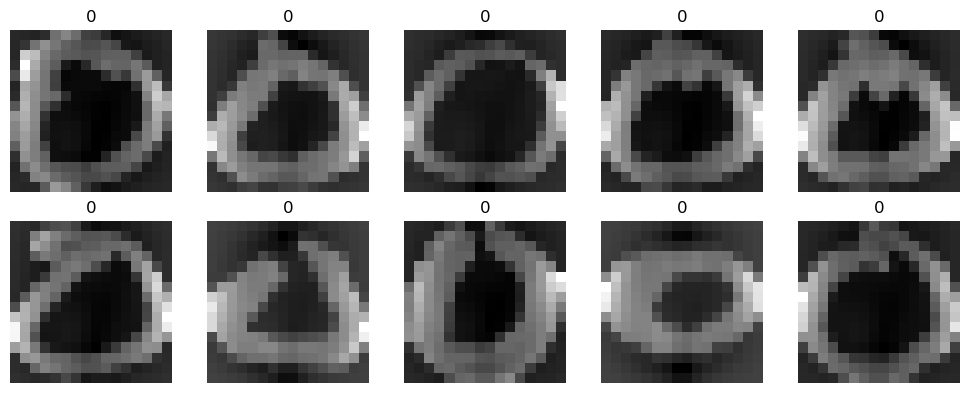

In [46]:
for i in range(10):
    print('cluster', i)
    afficher_images_cluster(groupes_df[i])

## Representations

In [28]:
representations_latentes = np.array([net.get_representation_latente(trainx[i].reshape((1,256))) for i in range(len(trainx))])
representations_latentes = np.squeeze(representations_latentes)
representations_latentes

array([[-1.,  1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1.,  1.],
       ...,
       [-1., -1., -1., ..., -1.,  1., -1.],
       [-1.,  1.,  1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1.,  1., -1.]])

In [32]:
kmeans_rep = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(representations_latentes)
# Pour obtenir les étiquettes de cluster pour chaque image
labels_rep = kmeans_rep.predict(representations_latentes)
image_cluster_rep = []
# Afficher les étiquettes de cluster pour chaque image
for i in range(len(labels_rep)):
    print("L'image", i, "appartient au cluster", labels_rep[i])
    image_cluster_rep.append((i,labels_rep[i]))


L'image 0 appartient au cluster 3
L'image 1 appartient au cluster 1
L'image 2 appartient au cluster 6
L'image 3 appartient au cluster 7
L'image 4 appartient au cluster 1
L'image 5 appartient au cluster 3
L'image 6 appartient au cluster 6
L'image 7 appartient au cluster 2
L'image 8 appartient au cluster 1
L'image 9 appartient au cluster 2
L'image 10 appartient au cluster 0
L'image 11 appartient au cluster 3
L'image 12 appartient au cluster 2
L'image 13 appartient au cluster 2
L'image 14 appartient au cluster 8
L'image 15 appartient au cluster 7
L'image 16 appartient au cluster 7
L'image 17 appartient au cluster 0
L'image 18 appartient au cluster 5
L'image 19 appartient au cluster 2
L'image 20 appartient au cluster 2
L'image 21 appartient au cluster 0
L'image 22 appartient au cluster 7
L'image 23 appartient au cluster 7
L'image 24 appartient au cluster 6
L'image 25 appartient au cluster 7
L'image 26 appartient au cluster 1
L'image 27 appartient au cluster 8
L'image 28 appartient au clust

In [39]:
df = pd.DataFrame(image_cluster_rep, columns=['RepresentationLatente', 'Cluster'])
df

,RepresentationLatente,Cluster
0,0,3
1,1,1
2,2,6
3,3,7
4,4,1
...,...,...
995,995,8
996,996,8
997,997,5
998,998,3


In [40]:
groupes = df.groupby('Cluster')
groupes_df = []
# Parcourir chaque groupe
for cluster, groupe_df in groupes:
    print("Cluster", cluster)
    print(groupe_df)
    groupes_df.append(groupe_df)
    print("\n")

Cluster 0
     RepresentationLatente  Cluster
10                      10        0
17                      17        0
21                      21        0
84                      84        0
96                      96        0
100                    100        0
133                    133        0
143                    143        0
148                    148        0
190                    190        0
211                    211        0
262                    262        0
265                    265        0
307                    307        0
360                    360        0
407                    407        0
415                    415        0
462                    462        0
493                    493        0
514                    514        0
521                    521        0
562                    562        0
566                    566        0
601                    601        0
613                    613        0
636                    636        0
653               

cluster 0


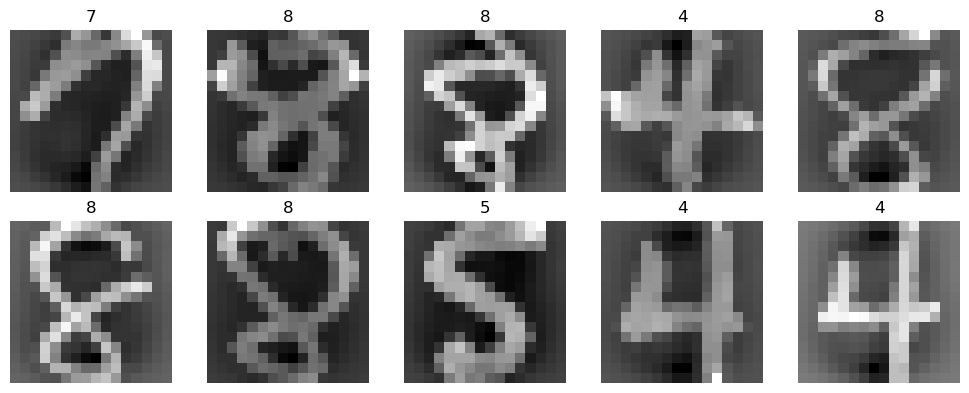

cluster 1


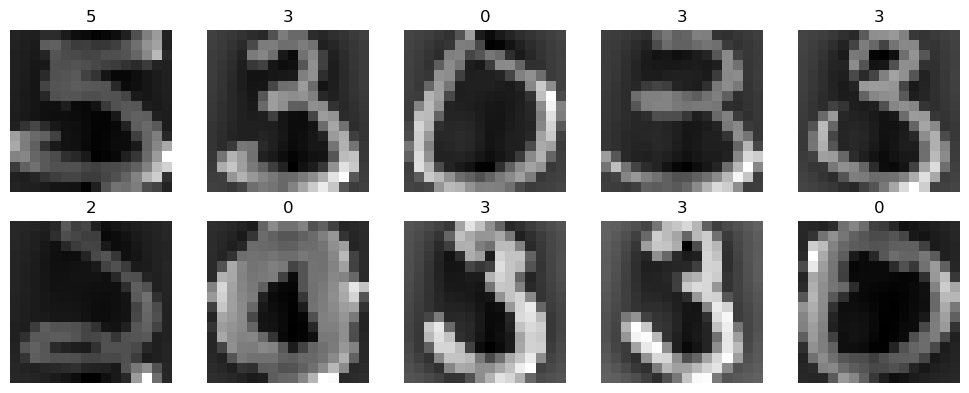

cluster 2


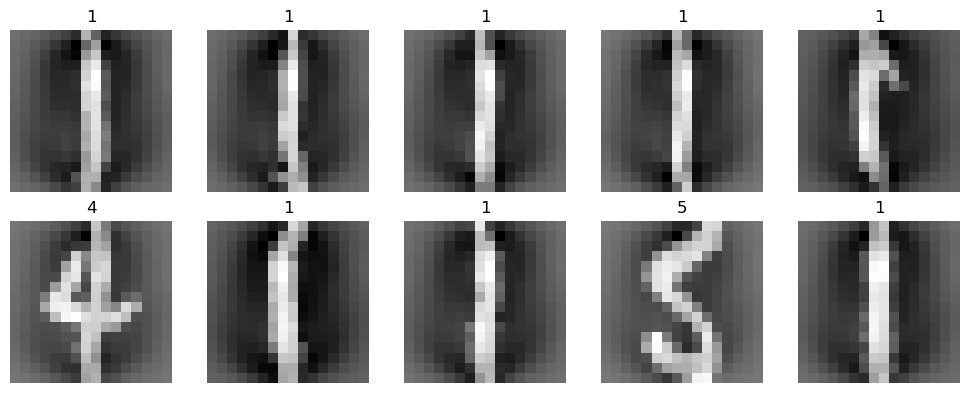

cluster 3


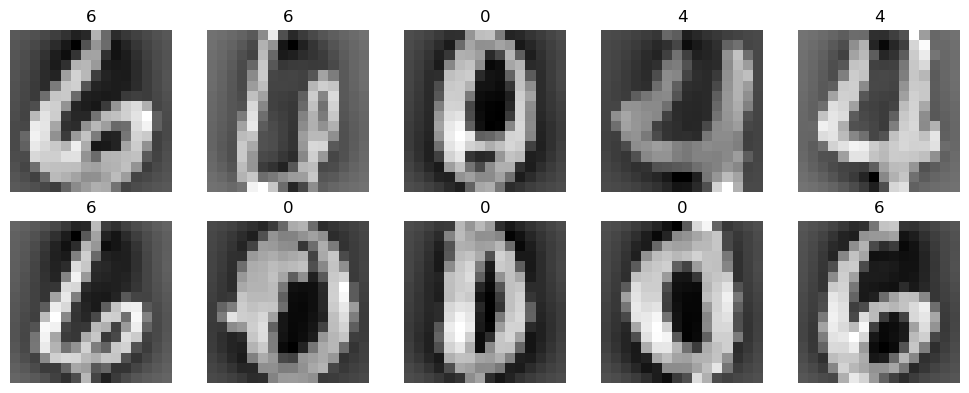

cluster 4


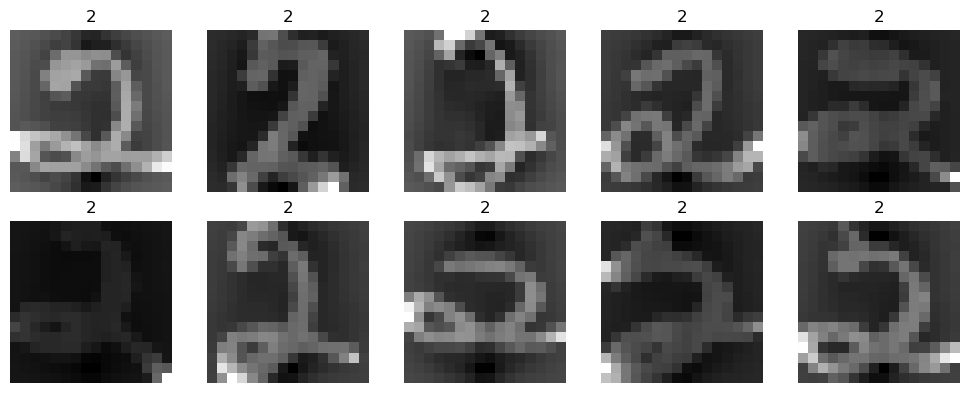

cluster 5


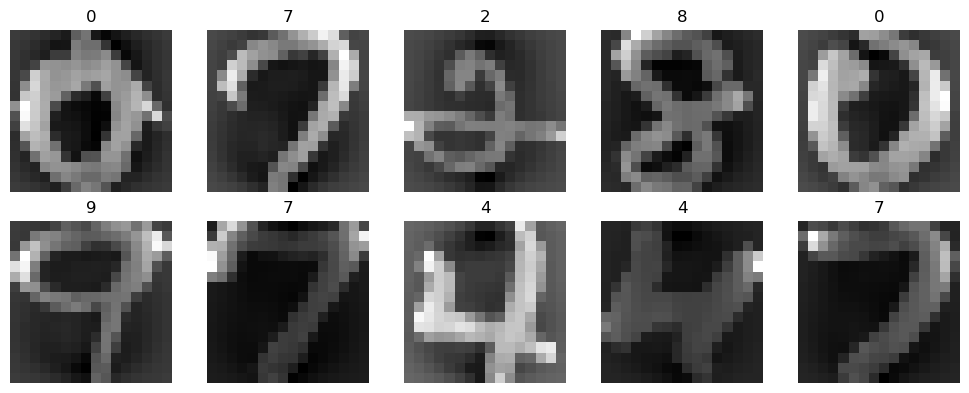

cluster 6


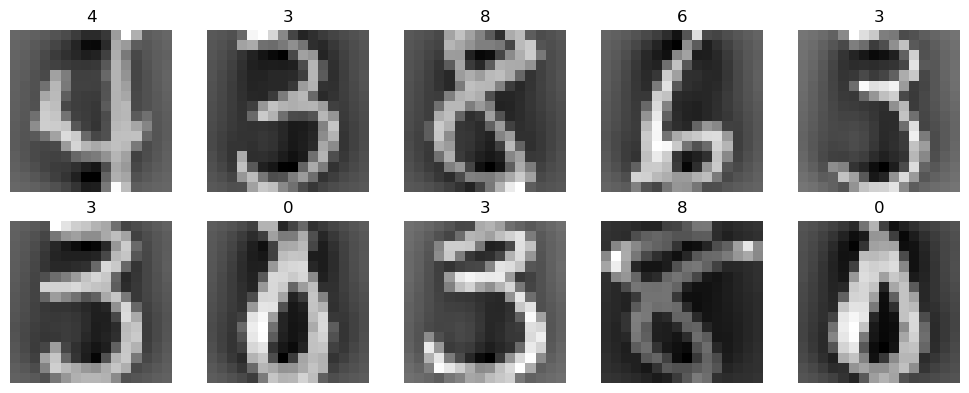

cluster 7


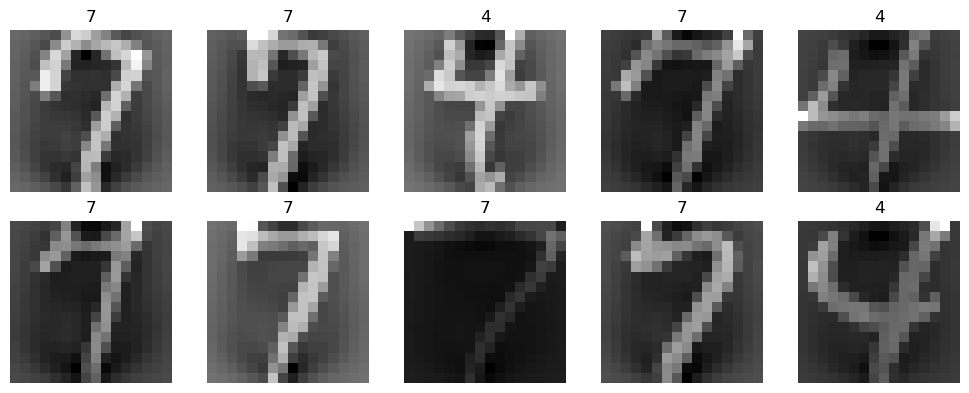

cluster 8


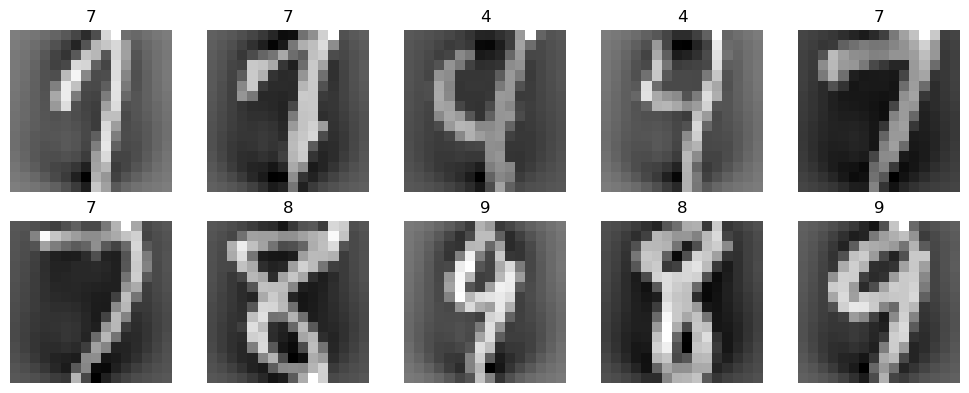

cluster 9


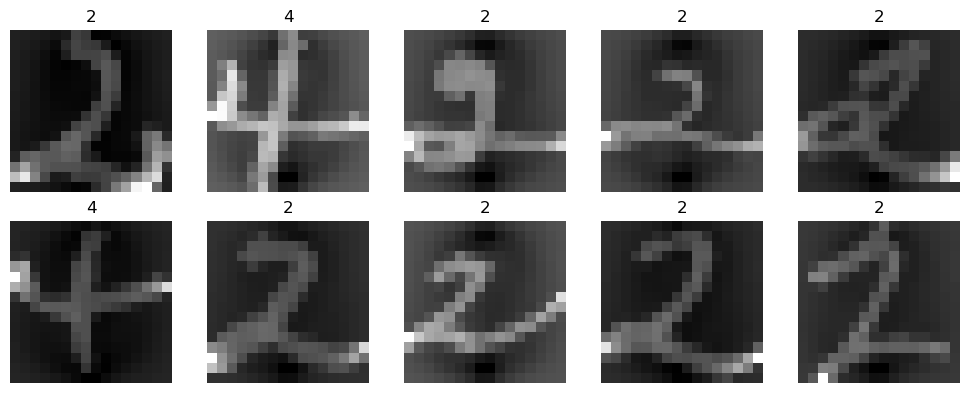

In [43]:
for i in range(10):
    print('cluster', i)
    afficher_images_cluster_rep(groupes_df[i])

# Classification

In [13]:
train_y = train_y[:1000].reshape(-1, 1)

In [65]:
np.savetxt('representations_latentes.txt', representations_latentes)

In [7]:
representations_latentes = np.loadtxt('representations_latentes.txt')

In [19]:
ic(representations_latentes.shape)
ic(train_y.shape)
X_train, X_test, y_train, y_test = train_test_split(representations_latentes, train_y, test_size=0.2, random_state=42)

# y_train_one_hot=[]
# for y in y_train:
#     y_train_one_hot.append(transform_one_hot(y))
    
# y_train_one_hot = np.array(y_train_one_hot)


# y_test_one_hot=[]
# for y in y_test:
#     y_test_one_hot.append(transform_one_hot(y))
    
# y_test_one_hot = np.array(y_test_one_hot)


#ic(X_train.shape, y_train_one_hot.shape) (800,10), (800,10)

loss_celogsoftmax = CELogSoftMax()
softmax = SoftMax()

net2 = Sequentiel(Linear(10, 80, 'lin1'), Tanh(), Linear(80, 10, 'lin2'), softmax)
net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=1000, eps=1e-2, shuffle=False)


ic| representations_latentes.shape: (1000, 10)
ic| train_y.shape: (1000, 1)
ic| X.shape: (800, 10), Y.shape: (800, 10)


ic| X.shape: (800, 10), Y.shape: (800, 10)


accuracy :  (541, 0.67625)


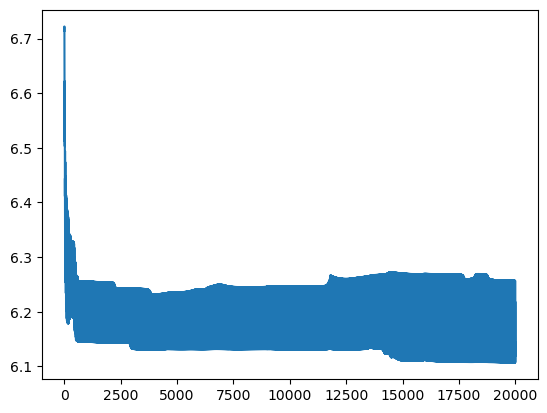

In [30]:
net2 = Sequentiel(Linear(10, 80, 'lin1'), Tanh(), Linear(80, 10, 'lin2'), softmax)
net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=2000, eps=1e-2, shuffle=True)

raw_scores = net2.forward(X_train)
print("accuracy : ", score(y_train_one_hot, raw_scores))
plt.plot(np.arange(len(couts2)), couts2)

In [ ]:
print("accuracy : ", score(y_test_one_hot, raw_scores))

ic| X.shape: (800, 10), Y.shape: (800, 10)


accuracy :  (534, 0.6675)


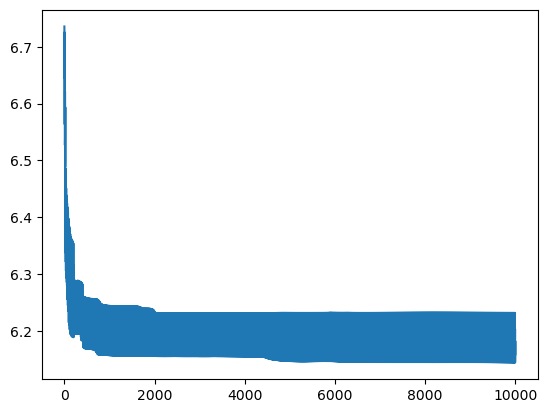

In [20]:
# net2 = Sequentiel(Linear(10, 80, 'lin1'), Tanh(), Linear(80, 10, 'lin2'), softmax)
# net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=1000, eps=1e-2, shuffle=False)

raw_scores = net2.forward(X_train)
print("accuracy : ", score(y_train_one_hot, raw_scores))
plt.plot(np.arange(len(couts2)), couts2)

accuracy :  (471, 0.58875)


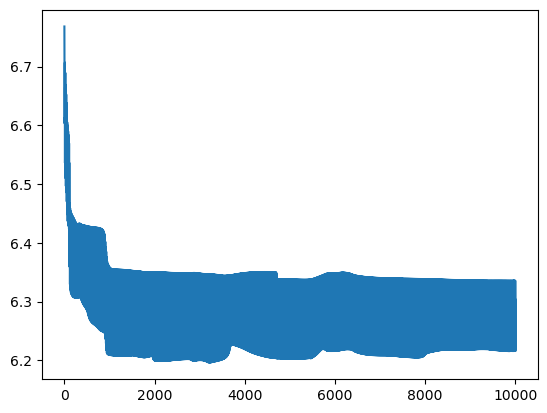

In [18]:
# net2 = Sequentiel(Linear(10, 32, 'lin1'), Tanh(), Linear(32, 10, 'lin2'), softmax)
# net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=1000, eps=1e-2, shuffle=False)
raw_scores = net2.forward(X_train)
print("accuracy : ", score(y_train_one_hot, raw_scores))
plt.plot(np.arange(len(couts2)), couts2)

accuracy :  (532, 0.665)


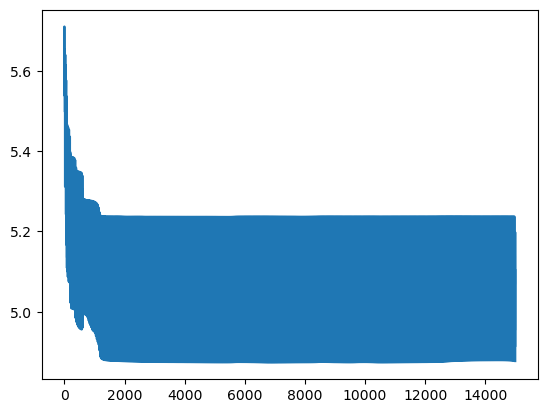

In [16]:
#net2 = Sequentiel(Linear(10, 80, 'lin1'), Tanh(), Linear(80, 10, 'lin2'), softmax)
#net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=30, loss=loss_celogsoftmax, nb_epochs=500, eps=1e-2, shuffle=False)

raw_scores = net2.forward(X_train)


print("accuracy : ", score(y_train_one_hot, raw_scores))
plt.plot(np.arange(len(couts2)), couts2)

## Classification avec autre dimension latente<>

In [7]:

    y_one_hot=[]
    for yi in y:
        y_one_hot.append(transform_one_hot(yi))
        
    return np.array(y_one_hot)

In [9]:
trainx = trainx[:1000,:]
train_y = train_y[:1000,:]

loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 80, init_type=1)
lineaire2 = Linear(80, 20, init_type=1)
lineaire3 = Linear(20, 80, init_type=1)
lineaire4 = Linear(80, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
#net = Sequentiel(lineaire1, tanh, lineaire4, sig)
#opt = Optim(net, loss_mse)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [8]:
X_train, X_test, y_train, y_test = train_test_split(representations_latentes, train_y, test_size=0.2, random_state=42)
y_train.shape

NameError: name 'representations_latentes' is not defined

In [ ]:



#ic(X_train.shape, y_train_one_hot.shape) (800,10), (800,10)

loss_celogsoftmax = CELogSoftMax()
softmax = SoftMax()

net2 = Sequentiel(Linear(10, 80, 'lin1'), Tanh(), Linear(80, 10, 'lin2'), softmax)
net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=1000, eps=1e-2, shuffle=False)



In [ ]:
representations_latentes = np.array([net2.get_representation_latente(trainx[i].reshape((1,256))) for i in range(len(trainx))])
representations_latentes = np.squeeze(representations_latentes)
representations_latentes